# Investigating volume imbalance
Two areas of interest:
Does a pure volume imbalance predict price movement?

Import the data

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
order_book = pd.read_csv("[market_data_2] order_book.csv")

def calculateVolumeImbalance(row):
    levels = ["0", "1", "2", "3", "4"]
    totalBids = sum([row["bidVol" + level] for level in levels])
    totalAsks = sum([row["askVol" + level] for level in levels])

    return 0 if totalBids + totalAsks == 0 else (totalBids - totalAsks) / (totalBids + totalAsks)

# add column for volume imbalance
order_book['volumeImbalance'] = order_book.apply(
    lambda row: calculateVolumeImbalance(row),
    axis = 1
)

# add mid
order_book['mid'] = order_book.apply(
    lambda row: (row['bidPrice0'] + row['askPrice0']) / 2,
    axis = 1
)

Plot a histogram of volume imbalance

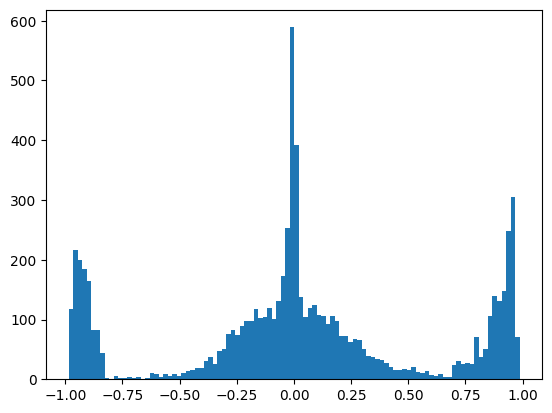

In [62]:
# plot the volume imbalance histogram
plt.hist(order_book['volumeImbalance'], bins = 100)
plt.show()

Looks like sensible to consider > 0.75, <-0.75


In [51]:
etf_book = order_book[order_book['instrument'] == "ETF"]

# we investigate how the mid shifts over each of these time intervals
tick_intervals = [1, 2, 5, 10, 15, 20, 25, 30]
TICK_SIZE = 0.25

def get_shifted_data(data, tick_intervals):
    tick_shift_not_found = 0 # see how often the data we are looking for exists

    shift_df = pd.DataFrame(columns=["time"] + tick_intervals)

    for index, row in data.iterrows():
        time = row['time']
        shift_data = {'time': time}
        for shift in tick_intervals:
            if not data[data['time'] == time + shift * TICK_SIZE].empty:
                # If the row exists, get the singular row with time t
                shifted_row = data[data['time'] == time + shift * TICK_SIZE].iloc[0]
                shift_data[shift] = (shifted_row['mid'] - row['mid']) / 100
            else:
                tick_shift_not_found += 1
                shift_data[shift] = 0

        shift_df.loc[len(shift_df)] = pd.Series(shift_data)

    return shift_df

Plot it!

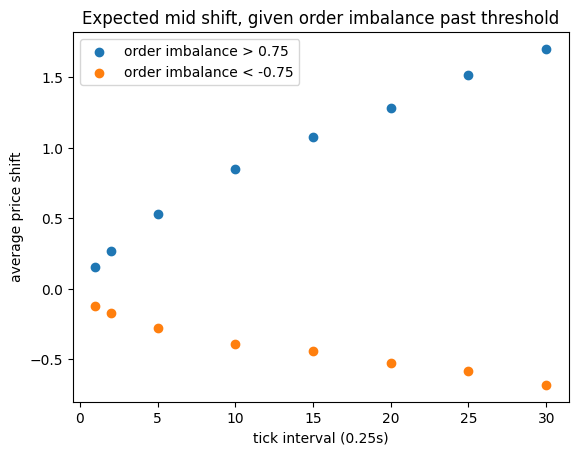

In [56]:
# now take column averages
bid_shifts = get_shifted_data(
    etf_book[etf_book['volumeImbalance'] > 0.75],
    tick_intervals
)
average_bid_shifts = bid_shifts[tick_intervals].mean()

ask_shifts = get_shifted_data(
    etf_book[etf_book['volumeImbalance'] < -0.75],
    tick_intervals
)
average_ask_shifts = ask_shifts[tick_intervals].mean()

plt.scatter(tick_intervals, average_bid_shifts, label="order imbalance > 0.75")
plt.scatter(tick_intervals, average_ask_shifts, label="order imbalance < -0.75")
plt.xlabel("tick interval (0.25s)")
plt.ylabel("average price shift ($)")
plt.title("Expected mid shift, given order imbalance past threshold")
plt.legend()
plt.show()

# Results
This is cool! Order imbalance is a real signal. The average is pretty weak eg. a shift of -0.5 expected after 30 seconds. Maybe I should increase the threshold?


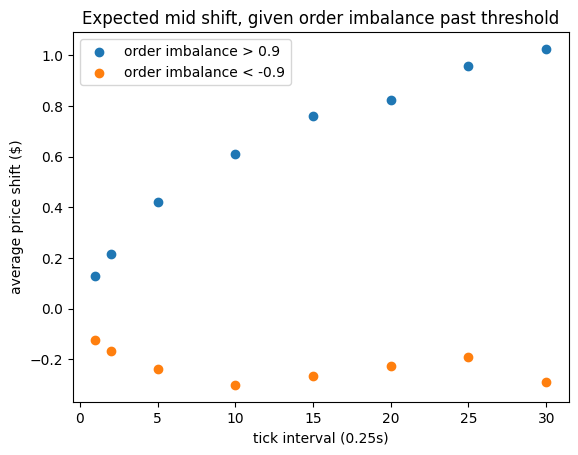

In [58]:
bid_shifts = get_shifted_data(
    etf_book[etf_book['volumeImbalance'] > 0.9],
    tick_intervals
)
average_bid_shifts = bid_shifts[tick_intervals].mean()

ask_shifts = get_shifted_data(
    etf_book[etf_book['volumeImbalance'] < -0.9],
    tick_intervals
)
average_ask_shifts = ask_shifts[tick_intervals].mean()

plt.scatter(tick_intervals, average_bid_shifts, label="order imbalance > 0.9")
plt.scatter(tick_intervals, average_ask_shifts, label="order imbalance < -0.9")
plt.xlabel("tick interval (0.25s)")
plt.ylabel("average price shift ($)")
plt.title("Expected mid shift, given order imbalance past threshold")
plt.legend()
plt.show()

# Interesting!
The signal becomes worse if we become more strict on signal criteria. I'd have expected it to get better. So I'm happy with the (-1, -0.7), (0.7, 1).

Takeaways:
1. Order balance as a signal exists.
2. For market_data_2, a target range of (-1, -0.7), (0.7, 1) works well
3. These average shifts could be calculated dynamically by the trader
4. It could make sense to shift prices slightly based on this criterion.